Importamos los datos de una nueva base de datos obtenida de `UC Irvine Machine Learning Repository`, donde queremos predecir si un hongo es venesoso o no. Esto se determina en la columna de `class_num`, donde un 1 indica que *si es venenoso* y por el contrario el 0 indicaria que *no lo es*. Ademas tenemos el diccionario de variables – UCI Mushroom, solo que cada característica en el dataset original estaba representada por una letra (código). Después de aplicar one-hot encoding, cada posible valor se convirtió en una columna booleana, pero conserva el mismo significado del diccionario mostrado a continuación.

## Variable objetivo
- **class**: `e` = edible (comestible), `p` = poisonous (venenoso)
- **class_num** (derivada): `0` = comestible, `1` = venenoso

## Variables originales (categóricas codificadas por letra)

### 1. cap-shape

- `b` = bell
- `c` = conical
- `x` = convex
- `f` = flat

### 2. cap-surface

- `f` = fibrous
- `g` = grooves
- `y` = scaly
- `s` = smooth

### 3. cap-color

- `n` = brown
- `b` = buff
- `c` = cinnamon
- `g` = gray
- `r` = green

### 4. bruises?

- `t` = bruises
- `f` = no

### 5. odor

- `a` = almond
- `l` = anise
- `c` = creosote
- `y` = fishy
- `f` = foul

### 6. gill-attachment

- `a` = attached
- `d` = descending
- `f` = free
- `n` = notched

### 8. gill-size

- `b` = broad
- `n` = narrow

### 9. gill-color

- `k` = black
- `n` = brown
- `b` = buff
- `h` = chocolate
- `g` = gray

### 10. stalk-shape

- `e` = enlarging
- `t` = tapering

### 11. stalk-root

- `b` = bulbous
- `c` = club
- `u` = cup
- `e` = equal

### 12. stalk-surface-above-ring

- `f` = fibrous
- `y` = scaly
- `k` = silky
- `s` = smooth

### 13. stalk-surface-below-ring

- `f` = fibrous
- `y` = scaly
- `k` = silky
- `s` = smooth

### 14. stalk-color-above-ring

- `n` = brown
- `b` = buff
- `c` = cinnamon
- `g` = gray
- `o` = orange

### 15. stalk-color-below-ring

- `n` = brown
- `b` = buff
- `c` = cinnamon
- `g` = gray
- `o` = orange

### 16. veil-type

- `p` = partial
- `u` = universal

### 17. veil-color

- `n` = brown
- `o` = orange
- `w` = white
- `y` = yellow

### 18. ring-number

- `n` = none
- `o` = one
- `t` = two

### 19. ring-type

- `c` = cobwebby
- `e` = evanescent
- `f` = flaring
- `l` = large

### 20. spore-print-color

- `k` = black
- `n` = brown
- `b` = buff
- `h` = chocolate
- `r` = green

### 21. population

- `a` = abundant
- `c` = clustered
- `n` = numerous

### 22. habitat

- `g` = grasses
- `l` = leaves
- `m` = meadows
- `p` = paths

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

df = pd.read_csv("mushroom_clean_onehot.csv")

print("Dimensiones:", df.shape)
print(df.head())

Dimensiones: (8124, 139)
   class_num  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0          1            0            0            0            0            0   
1          0            0            0            0            0            0   
2          0            1            0            0            0            0   
3          1            0            0            0            0            0   
4          0            0            0            0            0            0   

   cap-shape_x  cap-shape_nan  cap-surface_f  cap-surface_g  ...  \
0            1              0              0              0  ...   
1            1              0              0              0  ...   
2            0              0              0              0  ...   
3            1              0              0              0  ...   
4            1              0              0              0  ...   

   population_y  population_nan  habitat_d  habitat_g  habitat_l  habitat_m  \


Ahora separamos los datos en datos de entrenamiento (80%) y de prueba (20%), donde buscamos tener una proporcion equivalente en ambos lados y para eso usamos el parametro `stratify = y` dentro de la funcion `train_test_split`, donde igualamos a `y` porque este es la salida que debe estar bien distribuuida para ambas divisiones de los datos. Posteriormente imprimimos las dimensiones y las proporciones de cada conjunto de datos (original, test y train).

In [7]:
# Variable de salida
y = df["class_num"]

# Variables predictoras
X = df.drop(columns=["class_num"])

# Separar train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resultados 
print("Dimensiones totales:", X.shape)
print("Dimensiones train:", X_train.shape)
print("Dimensiones test:", X_test.shape)

print("\nDistribución en dataset completo:")
print(y.value_counts(normalize=True))

print("\nDistribución en train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en test:")
print(y_test.value_counts(normalize=True))

Dimensiones totales: (8124, 138)
Dimensiones train: (6499, 138)
Dimensiones test: (1625, 138)

Distribución en dataset completo:
class_num
0    0.517971
1    0.482029
Name: proportion, dtype: float64

Distribución en train:
class_num
0    0.517926
1    0.482074
Name: proportion, dtype: float64

Distribución en test:
class_num
0    0.518154
1    0.481846
Name: proportion, dtype: float64


En este paso aplicamos un proceso de **selección de características mixta** con el fin de reducir la dimensionalidad del dataset y quedarnos con las variables más significativas para el modelo.

**Selección hacia adelante (*Forward Selection*)**  
Se parte sin variables y se van agregando una por una, evaluando en cada paso cuál aporta mayor mejora al modelo, que en nuestro caso, se seleccionaron **10 características iniciales**.

**Selección hacia atrás (*Backward Selection*)**  
Sobre esas 10 variables se aplica el proceso inverso: se eliminan aquellas que menos contribuyen al desempeño, hasta quedarnos con **5 características finales**.

**Validación cruzada (5-fold)**  
Con estas 5 variables finales, entrenamos un modelo de **Regresión Logística**.  Se utilizó la técnica de **validación cruzada estratificada con 5 particiones** (`StratifiedKFold`), lo que permite medir la exactitud del modelo de manera más robusta, evitando que dependa de una sola división train/test. Y la función `cross_val_score` de *scikit-learn* calcula la métrica de desempeño en cada partición y luego promedia los resultados.

El resultado de este procedimiento nos da la exactitud media del modelo junto con su desviación estándar, además de mostrar las 5 variables seleccionadas que resultaron ser las más relevantes para predecir si un hongo es venenoso o comestible.


In [8]:
# Modelo base
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")

#Forward selection
sfs_forward = SequentialFeatureSelector(log_reg, n_features_to_select=10, direction="forward", cv=5, n_jobs=-1)
sfs_forward.fit(X_train, y_train)

X_train_forward = sfs_forward.transform(X_train)

#Backward selection 
sfs_backward = SequentialFeatureSelector(log_reg, n_features_to_select=5, direction="backward", cv=5, n_jobs=-1)
sfs_backward.fit(X_train_forward, y_train)

X_train_final = sfs_backward.transform(X_train_forward)

# Validación cruzada 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(log_reg, X_train_final, y_train, cv=cv, scoring="accuracy")

print("Exactitud media (5-fold CV):", scores.mean())
print("Desviación estándar:", scores.std())

# Extraer nombres de las 5 características finales
selected_forward = X_train.columns[sfs_forward.get_support()]
selected_final = selected_forward[sfs_backward.get_support()]
print("Características seleccionadas:", list(selected_final))

Exactitud media (5-fold CV): 0.9973842600817197
Desviación estándar: 0.0007843254888178732
Características seleccionadas: ['odor_a', 'odor_l', 'odor_n', 'stalk-color-below-ring_y', 'spore-print-color_r']


En este paso entrenamos un modelo de **Regresión Logística** utilizando todo el conjunto de entrenamiento.  
A diferencia de las predicciones binarias directas, el modelo nos entrega un **vector de probabilidades** (`predict_proba`) que indica la probabilidad de que cada hongo pertenezca a la clase `1` (venenoso).

Con estas probabilidades podemos fijar distintos **umbrales de decisión**:
- Si la probabilidad ≥ umbral → se clasifica como venenoso.
- Si la probabilidad < umbral → se clasifica como comestible.

Probamos con tres valores de umbral:
- **0.5** (estándar).
- **0.3** (más laxo → detecta más venenosos, aumenta la sensibilidad pero baja la especificidad).
- **0.7** (más estricto → reduce falsos positivos, aumenta la especificidad pero baja la sensibilidad).

Para cada umbral se calculan las siguientes métricas:
- **Matriz de confusión**: distribución de verdaderos positivos (TP), falsos positivos (FP), verdaderos negativos (TN) y falsos negativos (FN).
Exactitud (Accuracy): proporción de clasificaciones correctas:
$ \mathrm{Accuracy} = \dfrac{TP + TN}{TP + TN + FP + FN} $

Sensibilidad (Recall/TPR): proporción de positivos bien clasificados:
$ \mathrm{Recall} = \dfrac{TP}{TP + FN} $

Especificidad (TNR): proporción de negativos bien clasificados:
$ \mathrm{Specificity} = \dfrac{TN}{TN + FP} $

Este análisis permite observar cómo cambiar el umbral de decisión afecta el balance entre sensibilidad y especificidad, lo cual es clave en problemas donde un error puede ser muy costoso (por ejemplo, clasificar un hongo venenoso como comestible).


In [9]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# modelo con TODO el set de entrenamiento 
model = LogisticRegression(max_iter=1000, solver="liblinear")
model.fit(X_train, y_train)

# Vector de probabilidades para el set de prueba 
y_pred_proba = model.predict_proba(X_test)[:,1]

# Definir función para evaluar métricas con diferentes umbrales 
def evaluar_umbral(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nUmbral = {threshold}")
    print("Matriz de confusión:\n", cm)
    print(f"Exactitud: {acc:.4f}")
    print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
    print(f"Especificidad: {especificidad:.4f}")

# --- Evaluar en 3 umbrales ---
for thr in [0.3, 0.5, 0.7]:
    evaluar_umbral(y_test, y_pred_proba, thr)



Umbral = 0.3
Matriz de confusión:
 [[842   0]
 [  0 783]]
Exactitud: 1.0000
Sensibilidad (Recall): 1.0000
Especificidad: 1.0000

Umbral = 0.5
Matriz de confusión:
 [[842   0]
 [  1 782]]
Exactitud: 0.9994
Sensibilidad (Recall): 0.9987
Especificidad: 1.0000

Umbral = 0.7
Matriz de confusión:
 [[842   0]
 [  3 780]]
Exactitud: 0.9982
Sensibilidad (Recall): 0.9962
Especificidad: 1.0000


Con las probabilidades obtenidas en el modelo de Regresión Logística calculamos y graficamos la curva ROC (Receiver Operating Characteristic).  

- La curva ROC muestra el compromiso entre la **tasa de verdaderos positivos (Sensibilidad/TPR)** y la **tasa de falsos positivos (1 - Especificidad/FPR)** al variar el umbral de decisión.  La línea diagonal representa un modelo aleatorio (AUC = 0.5).  Cuanto más se acerque la curva a la esquina superior izquierda, mejor es la capacidad del modelo para discriminar entre clases.  

El área bajo la curva (**AUC**) se interpreta como la probabilidad de que el modelo asigne una puntuación mayor a un ejemplo positivo que a uno negativo tomado al azar.  
- **AUC = 1.0** → modelo perfecto.  
- **AUC = 0.5** → modelo sin capacidad de discriminación (equivalente a azar).  

En nuestro caso se obtuvo:  


AUC: 1.0000


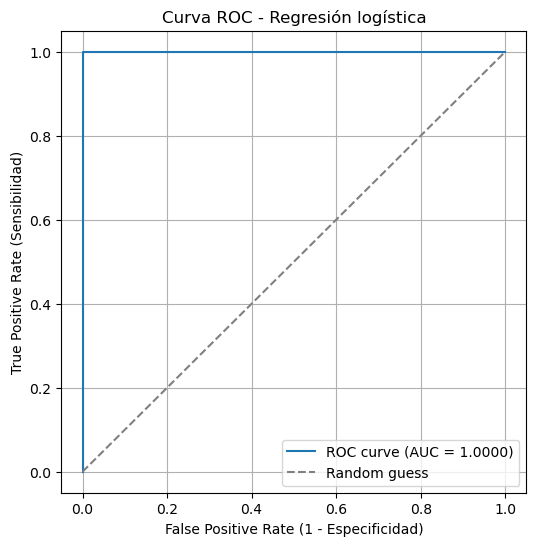

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Graficar ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guess")
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curva ROC - Regresión logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Los coeficientes del modelo muestran que tanto el olor como el color de impresión de esporas son atributos clave en la clasificación. Valores como odor=foul o odor=creosote, junto con spore-print-color=red, tienen coeficientes altamente positivos, lo que incrementa las odds de que un hongo sea venenoso. En contraste, olores como odor=almond o odor=anise, y colores de esporas como purple o white, presentan coeficientes negativos, asociados a hongos comestibles. Estos resultados confirman que el olor y las esporas son determinantes en la predicción.

In [14]:
coef = model.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({"Variable": features,"Coeficiente": coef,"Exp(coef)": np.exp(coef) }).sort_values(by="Coeficiente", ascending=False)

print(coef_df.head(10)) 
print("")
print(coef_df.tail(10))  


                       Variable  Coeficiente  Exp(coef)
118         spore-print-color_r     3.482413  32.538148
27                       odor_c     2.707282  14.988485
28                       odor_f     2.665768  14.378987
61                 stalk-root_b     2.378062  10.783983
32                       odor_p     2.217150   9.181130
43                  gill-size_n     2.122819   8.354654
45                 gill-color_b     1.830846   6.239164
67   stalk-surface-above-ring_k     1.763127   5.830642
39               gill-spacing_c     1.552417   4.722873
74   stalk-surface-below-ring_y     1.273511   3.573378

                Variable  Coeficiente  Exp(coef)
128         population_y    -1.154813   0.315116
119  spore-print-color_u    -1.313389   0.268907
115  spore-print-color_k    -1.369955   0.254118
40        gill-spacing_w    -1.456679   0.233009
108          ring-type_f    -1.532500   0.215995
116  spore-print-color_n    -1.591584   0.203603
42           gill-size_b    -2.027080   